In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### Looad data

In [21]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv")
df.head(2)

,Unnamed: 0,Date,Open_CHF_USD,Open_CHF_EUR,Open_CHF_GBP,Open_CHF_JPY,Open_CHF_CAD,Open_SMI,Open_USD_JPY,Open_USD_EUR,Open_USD_GBP,Open_USD_CAD,Open_SP500
0,0,2000-01-04,0.6428,0.6236,0.3906,64.85,0.9246,7484.8,101.46,0.9756,0.6115,1.4470,1455.2
1,1,2000-01-05,0.6429,0.6234,0.3926,66.34,0.9328,7153.1,103.28,0.9711,0.6101,1.4528,1399.4


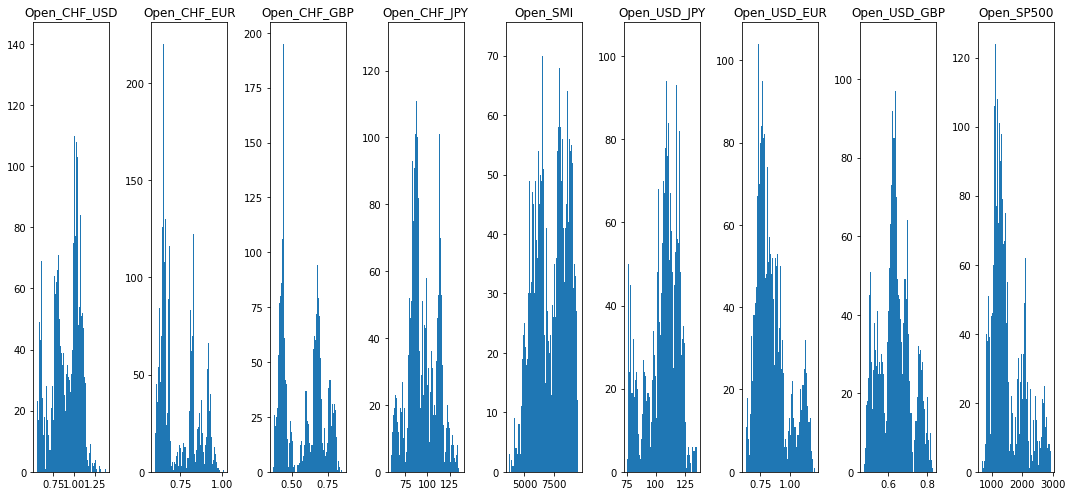

In [34]:
data = [
    df.Open_CHF_USD,

    df.Open_CHF_EUR,
    df.Open_CHF_GBP,
    df.Open_CHF_JPY,
    df.Open_SMI,
    df.Open_USD_JPY,
    df.Open_USD_EUR,
    df.Open_USD_GBP,
    df.Open_SP500]

fig = plt.figure(figsize=(15, 7))

name  = [
    'Open_CHF_USD',

	'Open_CHF_EUR',
    'Open_CHF_GBP',
    'Open_CHF_JPY',
    'Open_SMI',

    'Open_USD_JPY',
    'Open_USD_EUR',
    'Open_USD_GBP',
    'Open_SP500']

for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

0
0
27
Shape:             
X train     (3598, 7, 9), y train     (3598, 9)            
X train val (400, 7, 9) , y train val (400, 9)             
X test      (706, 7, 9) , y test      (706, 9)


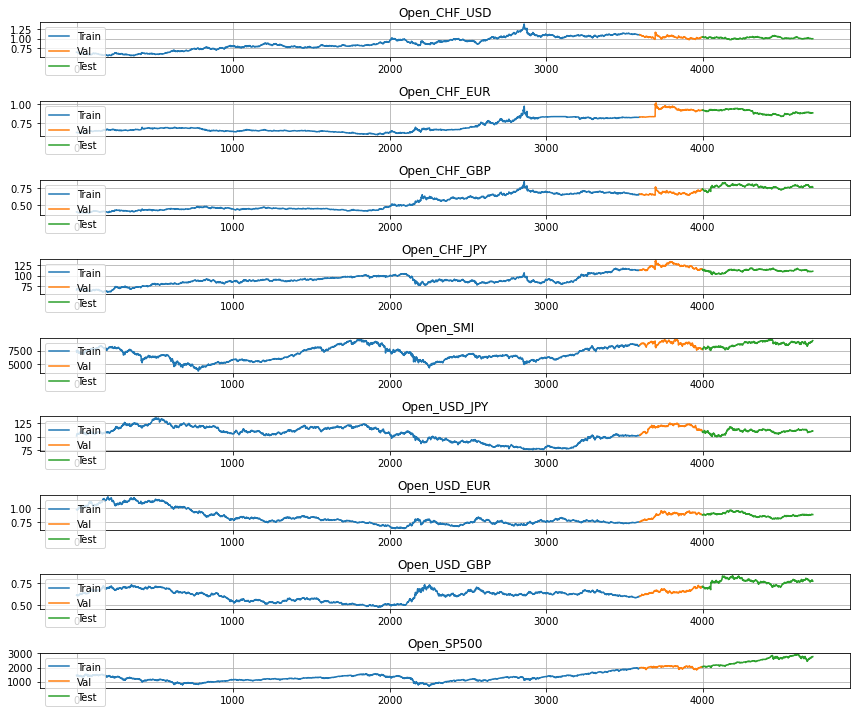

In [36]:
device = 'cpu'
LOOKBACK = 7

train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=3,
  norm_=True,
  fraction_val_=0.1,
  fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Trend Prediction

In [42]:
buff = train_y[:, 0]
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)

buff = test_y[:, 0]
buff.sum()/len(buff)

0.48583569405099153

### GRU 1-feature

In [38]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


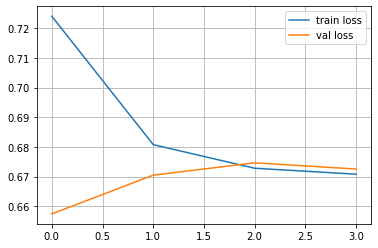

In [39]:
lr= 0.001
num_epochs= 50

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [41]:
_, _, ACC_gru_1 = pl.evaluate_trend(model_gru_1, val_x[:,:,0].reshape(-1, LOOKBACK,1), val_y[:, 0], device="cpu", verbose=1)


ACC:  0.55250
nb 0 = 295; nb 1 = 105


### GRU 9-feature

In [47]:
model_gru_9 = ml.GRU_base(
        hidden_size=50,
        num_layers=1,
        input_size=9,
        out_features_lin=50,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_9.to(device)
model_gru_9

GRU_base(
  (gru): GRU(9, 50, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=50, out_features=50, bias=True)
  (fc1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


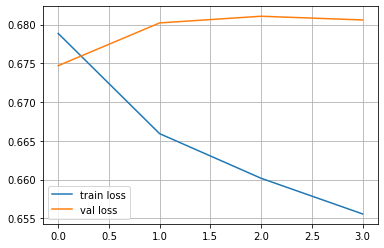

In [48]:
lr= 0.0001
num_epochs= 20

train_loss, val_loss = pl.train(
    model=model_gru_9,
    train_x_ = train_x,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [49]:
_, _, ACC_gru_9 = pl.evaluate_trend(model_gru_9, val_x, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.52000
nb 0 = 176; nb 1 = 224


### GRU + Auto-Encoder 1-feature 

In [227]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [240]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 40/40 [00:02<00:00, 18.15it/s]


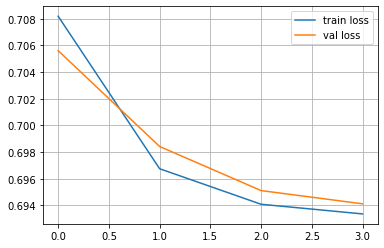

In [241]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 40

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [242]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

_, _, ACC_gru_autoenc_1 = pl.evaluate_trend(model_gru_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53525
nb 0 = 166; nb 1 = 217


### Dense + latent space Auto-Encoder 1-feature 

In [279]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


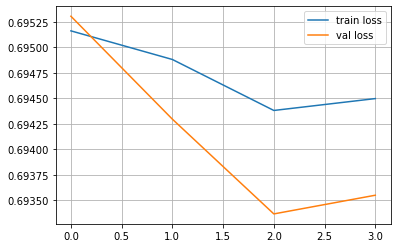

In [284]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 25 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [375]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out,latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

_, _, ACC_dense_autoenc_1 = pl.evaluate_trend(model_dense_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53786
nb 0 = 173; nb 1 = 210


### GRU + Auto-Encoder 5-feature 

In [397]:
model_autoenc_5 = ml.auto_encoder(input_size=5,
    nb_channel_conv=15)
model_autoenc_5.load_state_dict(torch.load('Helper/model/model_autoenc_5.pth'))
model_autoenc_5.to(device)
model_autoenc_5

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(5, 15, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(15, 5, kernel_size=(3,), stride=(1,))
)

In [398]:
model_gru_autoenc_5 = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size=5,
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_5.to(device)
model_gru_autoenc_5

GRU_base(
  (gru): GRU(5, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


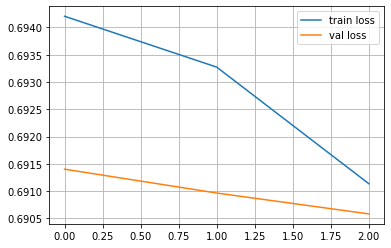

In [400]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_autoenc_5(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

lr= 0.0001
num_epochs= 17

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/3)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [401]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp3.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)


_, _, ACC_gru_autoenc_5 = pl.evaluate_trend(model_gru_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.52219
nb 0 = 173; nb 1 = 210


### Dense + latent space Auto-Encoder 5-feature 

In [361]:
model_dense_autoenc_5 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=15,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_5.to(device)
model_dense_autoenc_5

Dense(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 15/15 [00:00<00:00, 25.53it/s]


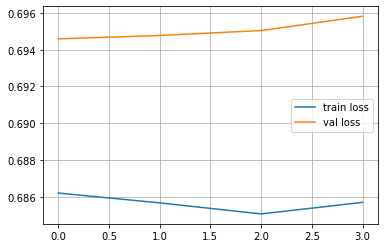

In [368]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_5(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

lr= 0.001
num_epochs= 15

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [373]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,15)

_, _, ACC_dense_autoenc_5 = pl.evaluate_trend(model_dense_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.48042
nb 0 = 153; nb 1 = 230


### Result 

In [377]:
print(f"ACC GRU 1-feature:                             { ACC_gru_1: 0.08f}")
print(f"ACC GRU 5-features:                            { ACC_gru_5: 0.08f}")
print(f"ACC GRU Auto-Encoder 1-feature:                { ACC_gru_autoenc_1: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 1-feature: { ACC_dense_autoenc_1: 0.08f}")
print(f"ACC GRU Auto-Encoder 5-feature:                { ACC_gru_autoenc_5: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 5-feature: { ACC_dense_autoenc_5: 0.08f}")


ACC GRU 1-feature:                              0.52219321
ACC GRU 5-features:                             0.54046997
ACC GRU Auto-Encoder 1-feature:                 0.53524804
ACC Dense latent space Auto-Encoder 1-feature:  0.53785901
ACC GRU Auto-Encoder 5-feature:                 0.54569191
ACC Dense latent space Auto-Encoder 5-feature:  0.48041775
